In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import pymc3 as pm
from scipy import stats
import theano.tensor as tt

%matplotlib inline

In [17]:
data = pd.read_csv('data.csv')
data.head()

,time,a_count,b_count
0,365.0,13.0,15.0
1,364.0,24.0,19.0
2,363.0,8.0,70.0
3,362.0,24.0,49.0
4,361.0,7.0,7.0


In [16]:
data

,time,a_count,b_count
0,365.0,13.0,15.0
1,364.0,24.0,19.0
2,363.0,8.0,70.0
3,362.0,24.0,49.0
4,361.0,7.0,7.0
5,360.0,35.0,53.0
6,359.0,14.0,22.0
7,358.0,11.0,21.0
8,357.0,15.0,31.0
9,356.0,11.0,19.0


In [6]:
count_data = np.array(
    [13., 24.,  8., 24.,  7., 35., 14., 11., 15., 11., 22., 22., 11.,
       57., 11., 19., 29.,  6., 19., 12., 22., 12., 18., 72., 32.,  9.,
        7., 13., 19., 23., 27., 20.,  6., 17., 13., 10., 14.,  6., 16.,
       15.,  7.,  2., 15., 15., 19., 70., 49.,  7., 53., 22., 21., 31.,
       19., 11., 18., 20., 12., 35., 17., 23., 17.,  4.,  2., 31., 30.,
       13., 27.,  0., 39., 37.,  5., 14., 13., 22.]
)
n_count_data = len(count_data)

In [14]:
pd.DataFrame(count_data).take

TypeError: 'instancemethod' object has no attribute '__getitem__'

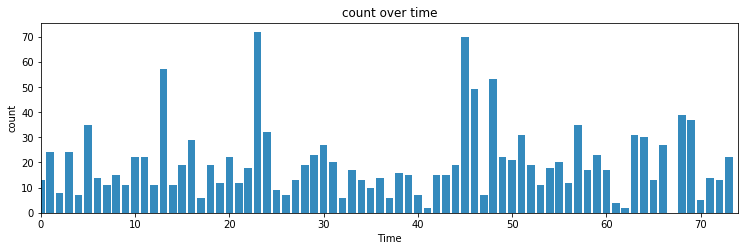

In [65]:
figsize(12.5, 3.5)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time")
plt.ylabel("count")
plt.title("count over time")
plt.xlim(0, n_count_data);

In [66]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [67]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:10<00:00, 2023.28draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [68]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

lambda_1_mode = stats.mode(lambda_1_samples)[0][0]
lambda_2_mode = stats.mode(lambda_2_samples)[0][0]
tau_mode = stats.mode(tau_samples)[0][0]

In [69]:
print(lambda_1_samples.mean())
print(lambda_2_samples.mean())
print(tau_samples.mean())

17.763882677647068
22.715743557693482
44.321


In [70]:
print(lambda_1_mode)
print(lambda_2_mode)
print(tau_mode)

18.15702549258325
21.966147502666445
45


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


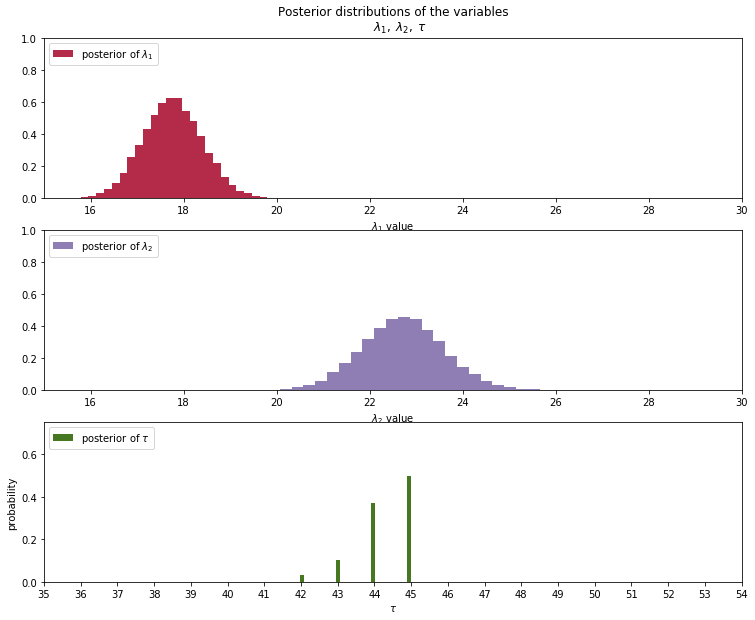

In [71]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$")
plt.ylabel("probability");

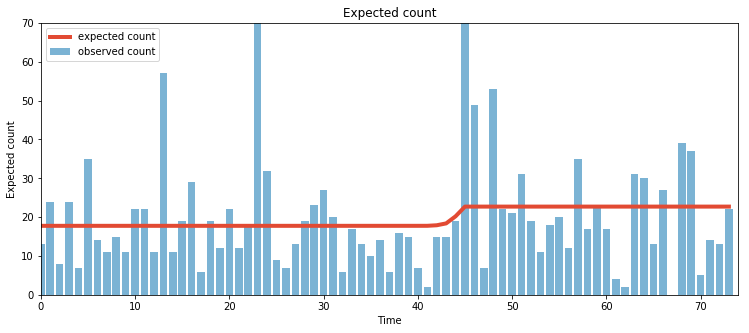

In [72]:
figsize(12.5, 5)

N = tau_samples.shape[0]
expected_count = np.zeros(n_count_data)
for t in range(0, n_count_data):
    ix = t < tau_samples
    expected_count[t] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

plt.plot(range(n_count_data), expected_count, lw=4, color="#E24A33",
         label="expected count")
plt.xlim(0, n_count_data)
plt.xlabel("Time")
plt.ylabel("Expected count")
plt.title("Expected count")
plt.ylim(0, 70)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed count")

plt.legend(loc="upper left");

Text(0.5, 0, 'count data')

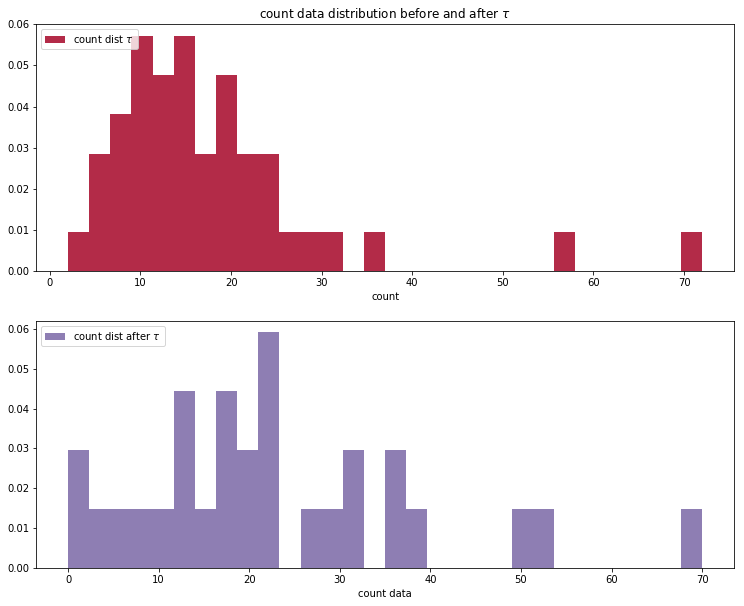

In [73]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(211)

plt.hist(count_data[:tau_mode], histtype='stepfilled', bins=30, alpha=0.85,
         label=r"count dist $\tau$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""count data distribution before and after $\tau$""")
plt.xlabel("count")

ax = plt.subplot(212)
plt.hist(count_data[tau_mode:], histtype='stepfilled', bins=30, alpha=0.85,
         label=r"count dist after $\tau$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlabel("count data")